### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
import pydot
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [2]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final.csv', header=1)
df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']

Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)

(-0.1899385741871933, 0.012062935912190395)

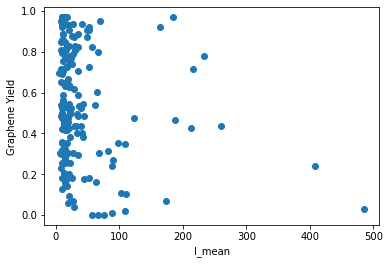

In [3]:
plt.scatter(df['I_Final'], df['Graphene_Yield'])
#plt.xlim(0, 1000)
plt.xlabel('I_mean');
plt.ylabel('Graphene Yield');

pearsonr(df['I_Final'], df['Graphene_Yield'])

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

<AxesSubplot:xlabel='I_Final', ylabel='Density'>

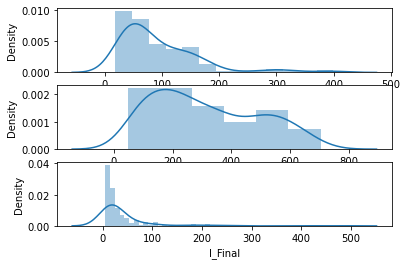

In [4]:
ax1 = plt.subplot(311)
sns.distplot (df['I_Mean'])
# add a subplot with no frame
ax2 = plt.subplot(312)
sns.distplot (df['I_Max']) 

ax3 = plt.subplot(313)
sns.distplot (df['I_Final'])

In [5]:
scaler = MinMaxScaler()
scaler.fit(np.array(df['I_Max']).reshape(-1, 1))

print(scaler.data_max_)
norm01_I_Max = scaler.transform(np.array(df['I_Max']).reshape(-1, 1))

[703.4397]


(0.7050712167737785, 9.134003863410962e-08)

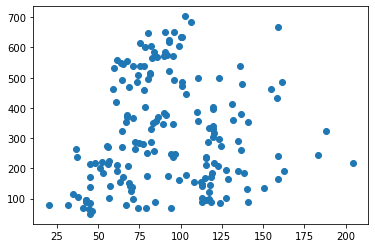

In [6]:
plt.scatter (df['charge_density'], df['I_Max'])
pearsonr(df['Voltage'][df['Material']=='MC'], df['I_Max'][df['Material']=='MC'])

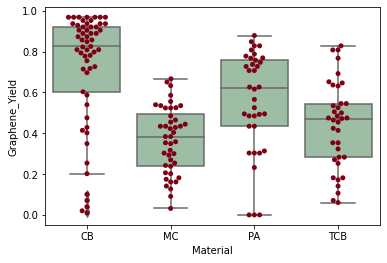

21.32217561441884 8.997595190802731e-12


In [7]:
# distribution of Voltage for different materials
import seaborn as sns
interest = 'Graphene_Yield'
ax = sns.boxplot(x='Material', y=interest, data=df, color='#99c2a2')
ax = sns.swarmplot(x="Material", y=interest, data=df, color='#7d0013')
plt.show()

import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(
    df[interest].loc[df['Material']=='CB'], 
    df[interest].loc[df['Material']=='MC'], 
    df[interest].loc[df['Material']=='TCB'], 
    df[interest].loc[df['Material']=='PA']
)
print(fvalue, pvalue)

[703.4397]
r2_score:  0.2458233875214847


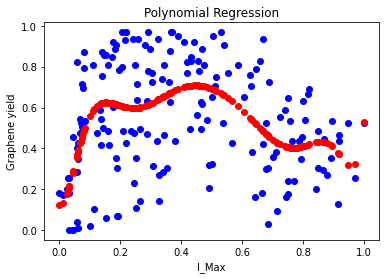

In [8]:
scaler = MinMaxScaler()
scaler.fit(np.array(df['I_Max']).reshape(-1, 1))

print(scaler.data_max_)
norm01_I_Max = scaler.transform(np.array(df['I_Max']).reshape(-1, 1))

#X = np.array(df['I_Max']).reshape(-1, 1)
X = norm01_I_Max
y= np.array (df['Graphene_Yield'])
poly = PolynomialFeatures(degree = 10)
X_poly = poly.fit_transform(X)
  
poly.fit(X_poly, y)
lin2 = LinearRegression()

lin2.fit(X_poly, y)
print ('r2_score: ', r2_score (y, lin2.predict(poly.fit_transform(X))))

plt.scatter(X, y, color = 'blue')
plt.scatter(X, lin2.predict(poly.fit_transform(X)), color = 'red')
plt.title('Polynomial Regression')
plt.xlabel('I_Max')
plt.ylabel('Graphene yield')
  
plt.show()

In [9]:
# mean (I_Final) = 40.8035 for the origianl dataset
# mean (I_Max) = 312.4003 for the origianl dataset
print ('mean (I_Final): ', np.mean(df['I_Final']))
print ('mean (I_Max): ', np.mean(df['I_Max']))

mean (I_Final):  40.80352983960345
mean (I_Max):  312.40027568965513


(0.34268553873628654, 3.680011667448526e-06)
(0.6090857528283637, 4.7813512297426555e-19)


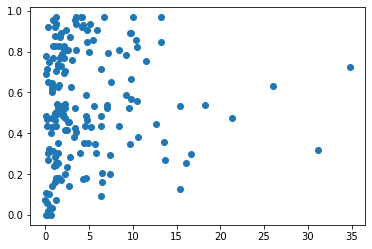

In [10]:
plt.scatter (df['Volt_Drop']/df['I_Mean']/df['Fin_R'], df['Graphene_Yield'])
print (pearsonr (df['Volt_Drop']/df['I_Mean'], df['Graphene_Yield']))
print (pearsonr (df['charge_density'], df['Graphene_Yield']))

In [11]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)
# extra material descriptors
# Cabot BP2000: Tensile Strength=17 MPa, particle size=15nm, specific surface area=1500(m2/g)
# metallurgical coke: grain size=150-210 (um)
# pyrolysis ash: 
# pyrolyzed rubber tire-derived carbon black: 

In [12]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [13]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)

(0.6761394202756715, 6.011449257022206e-06)
(0.5223532228602892, 0.0010833533507464777)


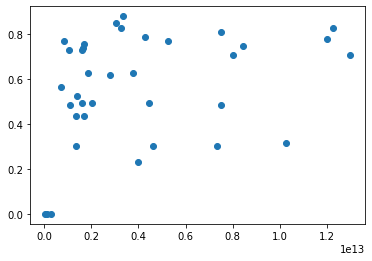

In [14]:
voltage_PA = df['Voltage'].loc[df['Material']=='PA']
mass_PA = df['Mass'].loc[df['Material']=='PA']
cap_PA = df['Cap'].loc[df['Material']=='PA']
GY_PA = df['Graphene_Yield'].loc[df['Material']=='PA']
CD_PA = df['charge_density'].loc[df['Material']=='PA']
prevol_PA = df['Pretreat_voltage'].loc[df['Material']=='PA']
prevolhighest_PA = df['Pretreat_voltage'].loc[df['Material']=='PA']
I_Max_PA = df['I_Max'].loc[df['Material']=='PA']
I_Mean_PA = df['I_Mean'].loc[df['Material']=='PA']
charge_tot_PA = df['Charge_Tot'].loc[df['Material']=='PA']

plt.scatter (((voltage_PA**1)/(mass_PA**-1)*(cap_PA**1))**3*1e-8
                +(prevol_PA**0.5) 
                +(I_Max_PA**0.8)
                +(charge_tot_PA**1)
                ,GY_PA)

print (pearsonr((voltage_PA**1)/(mass_PA**0.5)*(cap_PA**0.5) 
                +(prevol_PA**0.5) 
                +(I_Max_PA**0.8)
                +(charge_tot_PA**1)
                ,GY_PA))
print (pearsonr((voltage_PA**1)/(mass_PA**1)*cap_PA**1, GY_PA))

coef_:  [ 4.65014400e-02  8.71587861e-01  1.80761247e-01  4.75410878e-03
 -2.99822265e+01 -1.03776044e-01  4.18954972e-03  5.44358301e+10
  3.65661053e+10  1.96759004e+10 -7.04304629e+10]
(0.816515582065725, 1.138675901499027e-06)
r-squared 0.6264235829630727
mse:  0.019597922236543518


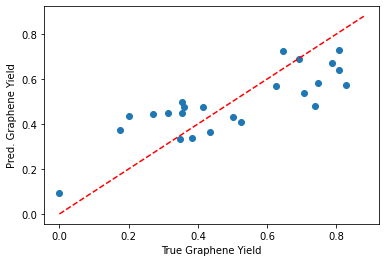

coef_:  [ 2.44459138e-01  7.33399417e-01  1.90765848e-01  4.70897812e-03
 -3.16294300e+01 -8.10531961e-02  7.56582075e-03  3.36970143e+08
  1.25855704e+08  1.39359955e+08 -4.10456220e+08]
(0.6927130936310956, 5.05223487151647e-18)
r-squared 0.4798514027372043
adj. r-squared 0.4253596449287209
mse:  0.02509351880745064
rmse:  0.15840933939465388
mae:  0.13038437369075523


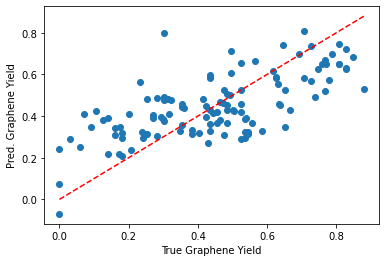

Text(0, 0.5, 'error of regression')

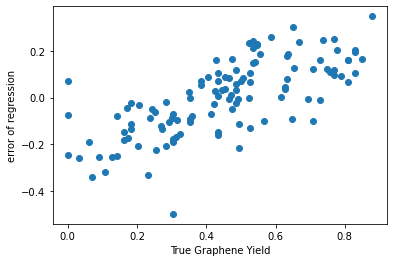

In [15]:
# linearly relate the input paramters to the final Graphene Yield
voltage_PA = np.array (df['Voltage'].loc[df['Material']!='CB']).reshape(-1, 1)
mass_PA = np.array (df['Mass'].loc[df['Material']!='CB']).reshape(-1, 1)
cap_PA = np.array (df['Cap'].loc[df['Material']!='CB']).reshape(-1, 1)
GY_PA = np.array (df['Graphene_Yield'].loc[df['Material']!='CB']).reshape(-1, 1)
CD_PA = np.array (df['charge_density'].loc[df['Material']!='CB']).reshape(-1, 1)
prevol_PA = np.array (df['Pretreat_voltage'].loc[df['Material']!='CB']).reshape(-1, 1)
prevolhighest_PA = np.array (df['Pretreat_voltage'].loc[df['Material']!='CB']).reshape(-1, 1)
I_Max_PA = np.array (df['I_Max'].loc[df['Material']!='CB']).reshape(-1, 1)
I_Mean_PA = np.array (df['I_Mean'].loc[df['Material']!='CB']).reshape(-1, 1)
charge_tot_PA = np.array (df['Charge_Tot'].loc[df['Material']!='CB']).reshape(-1, 1)
pulsetime_PA = np.array (df['PulseTime'].loc[df['Material']!='CB']).reshape(-1, 1)
maxima_PA = np.array (df['Maxima'].loc[df['Material']!='CB']).reshape(-1, 1)

input_features = np.concatenate(((voltage_PA**1*((mass_PA/100)**-1)*(cap_PA**1))**2*1e-9
                                 , (prevol_PA**0.5)*1e-2 
                                 , (I_Max_PA**0.8)*1e-2
                                 , pulsetime_PA**0.5
                                 , ((charge_tot_PA)**-2)*1e-2
                                 , mass_PA*1e-2 
                                 , cap_PA*1e-1
                                 , X_CB_MC_PA_TCB_ps_res_sa_sp2 [df['Material']!='CB']
                                   ), axis=1)

max_gamma_score = 0
for rand in range(0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_PA, test_size=0.2, random_state=rand)
    clf = linear_model.LinearRegression(fit_intercept=True, positive=False)
    clf = clf.fit(X_train, y_train.ravel())
    if clf.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = clf.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_PA, test_size=0.2, random_state=best_random_state)
clf = linear_model.LinearRegression(fit_intercept=True, positive=False)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
y_pred = clf.predict (X_test)

print (pearsonr(y_test.ravel(), y_pred.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')

mid_line = list(np.linspace(np.min(GY_PA), np.max(GY_PA), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()


clf = clf.fit(input_features, GY_PA.ravel())
print ('coef_: ', clf.coef_)
y_pred = clf.predict (input_features)
print (pearsonr(GY_PA.ravel(), y_pred.ravel()))
r2 = r2_score(GY_PA.ravel(), y_pred.ravel())
print ('r-squared', r2)
n = input_features.shape[0]
p = input_features.shape[1]
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print ('adj. r-squared', Adj_r2)
print ('mse: ', mean_squared_error(GY_PA, y_pred))
print ('rmse: ', np.sqrt(mean_squared_error(GY_PA, y_pred)))
print ('mae: ', mean_absolute_error(GY_PA, y_pred))


plt.scatter(GY_PA, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')
mid_line = list(np.linspace(np.min(GY_PA), np.max(GY_PA), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()

error = GY_PA - y_pred.reshape(-1, 1)
plt.scatter (GY_PA, (error))
plt.xlabel('True Graphene Yield')
plt.ylabel('error of regression')

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

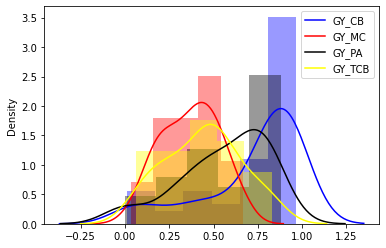

In [16]:
GY_CB = np.array (df['Graphene_Yield'].loc[df['Material'] =='CB']).reshape(-1, 1)
GY_MC = np.array (df['Graphene_Yield'].loc[df['Material'] =='MC']).reshape(-1, 1)
GY_PA = np.array (df['Graphene_Yield'].loc[df['Material'] =='PA']).reshape(-1, 1)
GY_TCB = np.array (df['Graphene_Yield'].loc[df['Material'] =='TCB']).reshape(-1, 1)

sns.distplot (GY_CB, color='blue')
sns.distplot (GY_MC, color='red')
sns.distplot (GY_PA, color='black')
sns.distplot (GY_TCB, color='yellow')
plt.legend(['GY_CB', 'GY_MC', 'GY_PA', 'GY_TCB'])

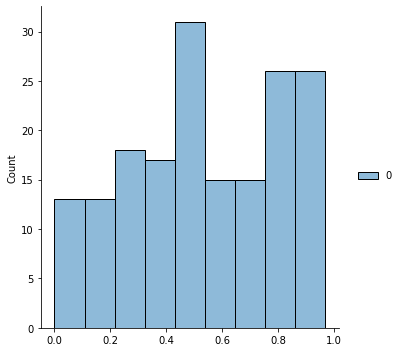

In [17]:
sns.displot (Graphene_Yield)

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/linear_model/_glm/glm.py:45: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.sum()], temp @ X))
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_v

coef_:  [ 0.85861131  1.26525739 -0.56478077 -0.85076473  0.12697614  0.00456595
 -0.01456464]
Gamma score: 0.6355360419927363
r-squared 0.41341153567808586
mse:  0.047195899137003325


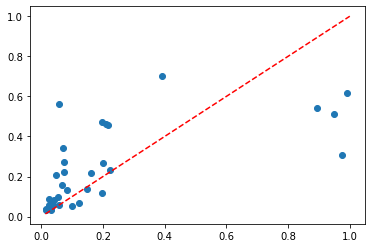

In [18]:
# Final_Current_Percent as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Final_Current_Percent
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix_cosh, Init_R, Res_Drop, Volt_Drop), axis=1)
max_gamma_score = 0
for rand in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=rand)
    clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    if clf.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = clf.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=best_random_state)
clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))


plt.scatter(y_test, y_pred)
mid_line = list(np.linspace(np.min(Final_Current_Percent), np.max(Final_Current_Percent), 8))
plt.plot(mid_line, mid_line, '--', color='red')

coef_:  [-0.12706507 -0.09505012  0.07616448 -0.26409503  0.00286348 -0.00347033
  0.00132296 -0.05904571 -0.02290511  0.00354556]
Gamma score for test data: 0.7109013006102891
r-squared for test data 0.7622299091094992
mse:  126323.37860388341


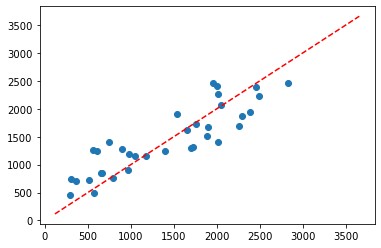

In [19]:
# Norm_I_Max as output of linear model with inputs Precursor related:
# Init_R, Res_Drop, Volt_Drop --> Norm_I_Max
input_features = np.concatenate((material_matrix_cosh, X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)], 
                                 Init_R, Res_Drop, Volt_Drop), axis=1)
max_gamma_score = 0
for rand in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=rand)
    clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    if clf.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = clf.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=best_random_state)
clf = linear_model.GammaRegressor(alpha=0., max_iter=10000)
clf = clf.fit(X_train, y_train.ravel())

print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score for test data:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared for test data', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
mid_line = list(np.linspace(np.min(Norm_I_Max), np.max(Norm_I_Max), 8))
plt.plot(mid_line, mid_line, '--', color='red')

coef_:  [-0.07910395 -0.32993876 -0.32547117 -0.20673999 -0.00854803  0.01448827
  0.00882141]
Gamma score: 0.7773710924599677
r-squared 0.7372262719721654
mse:  309.3488609203823


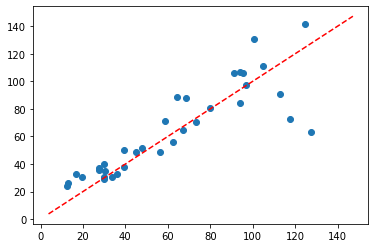

In [20]:
# Norm_charge_tot as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_charge_tot
input_features = np.concatenate((material_matrix, Init_R, Res_Drop, Volt_Drop), axis=1)
max_gamma_score = 0
for rand in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=rand)
    clf = linear_model.GammaRegressor(alpha=0., max_iter=1000)
    clf = clf.fit(X_train, y_train.ravel())
    if clf.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = clf.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=best_random_state)
clf = linear_model.GammaRegressor(alpha=0., max_iter=1000)
clf = clf.fit(X_train, y_train.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))


plt.scatter(y_test, y_pred)
mid_line = list(np.linspace(np.min(Norm_charge_tot), np.max(Norm_charge_tot), 8))
plt.plot(mid_line, mid_line, '--', color='red')

In [21]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

In [22]:
# proxy (current-time plot) prediction (Final_Current_percent)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=0
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_CB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']
new_features[0]

array([ 1.12800000e+02,  1.20000000e+03,  8.58611312e-01,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.00000000e+01])

In [23]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(50):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.01, 
                   learning_rate=0.115, subsample=0.77, min_child_weight=8, 
                   random_state=random_state)
    #xgbr_final_I_percent = RandomForestRegressor(max_depth=20, n_estimators=500, min_samples_split=3)
    # xgbr_final_I_percent = linear_model.BayesianRidge()
    # xgbr_final_I_percent = XGBRegressor()
    # Train the model on training data
    labels = Final_Current_Percent
    xgbr_final_I_percent.fit(train_new_features, train_labels);
    #print('Doneskies')
    Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
    r_squareds.append(r_squared_Final_Current_test)
    
    r_pearson_Final_Current_test = pearsonr(test_labels.reshape(test_labels.shape[0],), 
                                            Final_Current_Percent_test.reshape(Final_Current_Percent_test.shape[0],))
    r_pearsons.append(r_pearson_Final_Current_test[0])   
    
    Final_Current_Percent_train = xgbr_final_I_percent.predict(train_new_features)
    r_squared_Final_Current_train = r2_score(train_labels, Final_Current_Percent_train)
    r_squareds_train.append(r_squared_Final_Current_train)    

print ('Average of r pearson for test', np.mean(np.array(r_pearsons)))
print ('std of r pearson for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

xgbr_final_I_percent.fit(new_features, labels)
# Use the forest's predict method on the test data
Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)
# Calculate the absolute errors
errors = abs(Final_Current_Percent_predicted - Final_Current_Percent)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Final_Current_all = r2_score(Final_Current_Percent, Final_Current_Percent_predicted)
print('r2 score = ', r_squared_Final_Current_all)

# Use the forest's predict method on the test data
Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Final_Current_Percent_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
print('r2 score = ', r_squared_Final_Current_test)

Average of r pearson for test 0.7121996078082272
std of r pearson for test 0.01650218191687986 

Average of r_squared for test 0.482765645772217
std of r_squared for test 0.028407963803648528 

Average of r_squared for train 0.7893109433051783
std of r_squared for train 0.008087188736208731
Mean Absolute Error: 0.2072 units.
r2 score =  0.777848107305179
Mean Absolute Error: 0.1598 units.
r2 score =  0.7212958350290023


In [24]:
# Get numerical feature importances
importances = list(xgbr_final_I_percent.feature_importances_)
print (importances)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

[0.07375926, 0.48786104, 0.06047855, 0.11870212, 0.0075992225, 0.037053633, 0.059584334, 0.0, 0.15496178]
Variable: charge_denisty Importance: ('charge_denisty', 0.07)
Variable: PulseTime Importance: ('PulseTime', 0.49)
Variable: material_CB Importance: ('material_CB', 0.06)
Variable: material_MC Importance: ('material_MC', 0.12)
Variable: material_PA Importance: ('material_PA', 0.01)
Variable: material_CB Importance: ('material_CB', 0.04)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.0)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.15)


In [25]:
# proxy (current-time plot) prediction (Norm_I_Max)
new_features = np.concatenate ((charge_denisty,
                                #np.array (df['Voltage']).reshape(-1, 1),
                                pulsetime,
                                material_type_Norm_I_Max_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=0
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

(0.7895080655700772, 1.731054934952032e-08)
Average of pearson r for test 0.7810154834756273
std of pearson 1 for test 0.010085592493309297 

Average of r_squared for test 0.573356679659293
std of r_squared for test 0.013405545283271307 

Average of r_squared for train 0.6920682071470152
std of r_squared for train 0.00617061917438267
Mean Absolute Error: 718.5204 units.
r2 score =  0.690673533208469
Mean Absolute Error: 715.1021 units.
r2 score =  0.692127316379529


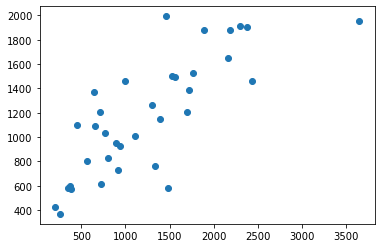

In [26]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    
    xgbr_norm_I_max = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=6, 
                  random_state=random_state)
    
    #xgbr_norm_I_max = RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_split=3)
    # xgbr_norm_I_max = linear_model.BayesianRidge()
    # xgbr_norm_I_max = XGBRegressor()
    # Train the model on training data
    labels = Norm_I_Max
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)

    test_labels_ = test_labels.reshape(test_labels.shape[0], )

    Norm_I_Max_test_ = Norm_I_Max_test.reshape(Norm_I_Max_test.shape[0], )

    r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
    r_pearsons.append(r_pearson_Norm_I_Max_test[0])
    r_squareds.append(r_squared_Norm_I_Max_test)
    
    Norm_I_Max_train = xgbr_norm_I_max.predict(train_new_features)
    r_squared_Norm_I_Max_train = r2_score(train_labels, Norm_I_Max_train)
    r_squareds_train.append(r_squared_Norm_I_Max_train)  

r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
print (r_pearson_Norm_I_Max_test)
plt.scatter(test_labels_, Norm_I_Max_test_)
print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')
print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')
print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

xgbr_norm_I_max.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_I_Max_predicted - Norm_I_Max)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_I_Max_all = r2_score(Norm_I_Max, Norm_I_Max_predicted)
print('r2 score = ', r_squared_Norm_I_Max_all)

# Use the forest's predict method on the test data
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_I_Max_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
print('r2 score = ', r_squared_Norm_I_Max_test)

In [27]:
# Get numerical feature importances
importances = list(xgbr_norm_I_max.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];
print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.14)
Variable: PulseTime Importance: ('PulseTime', 0.03)
Variable: material_CB Importance: ('material_CB', 0.0)
Variable: material_MC Importance: ('material_MC', 0.55)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_TCB Importance: ('material_TCB', 0.06)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.0)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.14)
[0.14157231, 0.029698309, 0.0, 0.5455658, 0.0, 0.06243607, 0.0, 0.08547817, 0.13524945]


In [28]:
# proxy (current-time plot) prediction (Norm_Norm_charge_tot)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=0
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

In [29]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_norm_charge_total = XGBRegressor(max_depth=10, n_estimators=100, gamma=0.01, 
                   learning_rate=0.118, subsample=0.75, min_child_weight=2, 
                  random_state=random_state)
    #xgbr_norm_charge_total = RandomForestRegressor(max_depth=5, n_estimators=200, min_samples_split=3)
    # xgbr_norm_charge_total = linear_model.BayesianRidge()
    # xgbr_norm_charge_total = XGBRegressor()
    # Train the model on training data
    labels = Norm_charge_tot
    xgbr_norm_charge_total.fit(train_new_features, train_labels);
    #print('Doneskies')
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    r_squareds.append(r_squared_Norm_charge_tot_test)
    
    test_labels_ = test_labels.reshape(test_labels.shape[0], )
    Norm_charge_tot_test_ = Norm_charge_tot_test.reshape(Norm_charge_tot_test.shape[0], )
    r_pearson_Norm_charge_tot_test = pearsonr(test_labels_, Norm_charge_tot_test_)
    r_pearsons.append(r_pearson_Norm_charge_tot_test[0])

    
    Norm_charge_tot_train = xgbr_norm_charge_total.predict(train_new_features)
    r_squared_Norm_charge_tot_train = r2_score(train_labels, Norm_charge_tot_train)
    r_squareds_train.append(r_squared_Norm_charge_tot_train)    

print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))


xgbr_norm_charge_total.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_charge_tot_predicted - Norm_charge_tot)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_charge_tot_all = r2_score(Norm_charge_tot, Norm_charge_tot_predicted)
print('r2 score = ', r_squared_Norm_charge_tot_all)

# Use the forest's predict method on the test data
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_charge_tot_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
print('r2 score = ', r_squared_Norm_charge_tot_test)

Average of pearson r for test 0.762857267170948
std of pearson 1 for test 0.025624120039653548 

Average of r_squared for test 0.5492208940617689
std of r_squared for test 0.034717596485303946 

Average of r_squared for train 0.9992018799936646
std of r_squared for train 0.00020163820884514097
Mean Absolute Error: 34.65 units.
r2 score =  0.9993209585434534
Mean Absolute Error: 37.4597 units.
r2 score =  0.9991980110720922


In [30]:
# Get numerical feature importances
importances = list(xgbr_norm_charge_total.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.12)
Variable: PulseTime Importance: ('PulseTime', 0.13)
Variable: material_CB Importance: ('material_CB', 0.08)
Variable: material_MC Importance: ('material_MC', 0.22)
Variable: material_PA Importance: ('material_PA', 0.03)
Variable: material_TCB Importance: ('material_TCB', 0.18)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.1)
[0.11565813, 0.13434339, 0.07814488, 0.21513005, 0.02933864, 0.18005373, 0.06032598, 0.085444376, 0.101560794]


In [31]:
print (CB_MC_PA_coef_Final_Current_Percent)
print (CB_MC_PA_coef_Norm_I_Max)
print (CB_MC_PA_coef_Norm_charge_tot)
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3
print (CB_MC_PA_TCB_coef_average)

[ 0.85861131  1.26525739 -0.56478077 -0.85076473]
[-0.12706507 -0.09505012  0.07616448 -0.26409503]
[-0.07910395 -0.32993876 -0.32547117 -0.20673999]
[ 0.21748076  0.2800895  -0.27136248 -0.44053325]


coef_:  [ 9.08424128e-01  4.60149659e-01  2.20912710e-02  5.49016676e-03
  1.34490720e-01  4.36209430e-02 -6.93143732e-03 -1.35534749e-02
  2.37964732e-02 -5.04548281e-04  2.55184502e-02]
(0.8082915990712103, 4.304960043067796e-09)
r-squared 0.639170307324442
mse:  0.02249125966641455


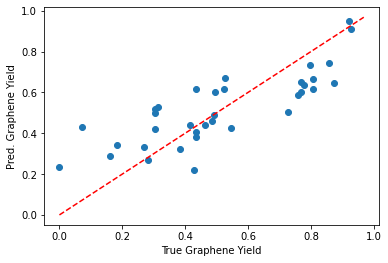

coef_:  [ 9.59641866e-01  9.51810841e-01  1.66744079e-02  5.25316467e-03
  1.46816811e-01  1.89868372e-02 -2.87146310e-03 -1.14242241e-02
  1.90227670e-02 -4.18080149e-04  2.00605327e-02]
(0.7510179691475156, 7.932790310419067e-33)
r-squared 0.5640279899824587
adj. r-squared 0.5344249522652182
mse:  0.03258386247376601
rmse:  0.18051000657516472
mae:  0.15076852961391476


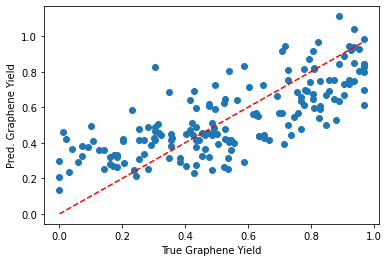

Text(0, 0.5, 'error of regression')

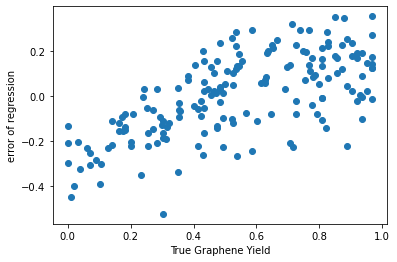

In [32]:
# linearly relate the input paramters to the final Graphene Yield
voltage_ALL = np.array (df['Voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
mass_ALL = np.array (df['Mass'].loc[df['Material']!='AAA']).reshape(-1, 1)
cap_ALL = np.array (df['Cap'].loc[df['Material']!='AAA']).reshape(-1, 1)
GY_ALL = np.array (df['Graphene_Yield'].loc[df['Material']!='AAA']).reshape(-1, 1)
CD_ALL = np.array (df['charge_density'].loc[df['Material']!='AAA']).reshape(-1, 1)
prevol_ALL = np.array (df['Pretreat_voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
prevolhighest_ALL = np.array (df['Pretreat_voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
I_Max_ALL = np.array (df['I_Max'].loc[df['Material']!='AAA']).reshape(-1, 1)
I_Mean_ALL = np.array (df['I_Mean'].loc[df['Material']!='AAA']).reshape(-1, 1)
charge_tot_ALL = np.array (df['Charge_Tot'].loc[df['Material']!='AAA']).reshape(-1, 1)
pulsetime_ALL = np.array (df['PulseTime'].loc[df['Material']!='AAA']).reshape(-1, 1)
maxima_ALL = np.array (df['Maxima'].loc[df['Material']!='AAA']).reshape(-1, 1)

                                #Final_Current_Percent_predicted.reshape(-1, 1),
                                #Norm_I_Max_predicted.reshape(-1, 1),
                                #Norm_charge_tot_predicted.reshape(-1, 1), 
            
input_features = np.concatenate(((voltage_ALL**1*((mass_ALL/100)**-1)*(cap_ALL**1))**2*1e-9
                                 , (prevol_ALL**0.5)*1e-2 
                                 , (Norm_I_Max_predicted.reshape(-1, 1)**1)*1e-2
                                 , pulsetime_ALL**0.5
                                 , ((Norm_charge_tot_predicted.reshape(-1, 1))**1)*1e-2
                                 , mass_ALL*1e-2 
                                 , cap_ALL*1e-1
                                 , X_CB_MC_PA_TCB_ps_res_sa_sp2 [df['Material']!='AAA']
                                   ), axis=1)

max_gamma_score = 0
for rand in range(0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_ALL, test_size=0.2, random_state=rand)
    phys_reg_mdl = linear_model.LinearRegression(fit_intercept=True, positive=False)
    phys_reg_mdl = phys_reg_mdl.fit(X_train, y_train.ravel())
    if phys_reg_mdl.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = phys_reg_mdl.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_ALL, test_size=0.2, random_state=best_random_state)
phys_reg_mdl = linear_model.LinearRegression(fit_intercept=True, positive=False)
phys_reg_mdl = phys_reg_mdl.fit(X_train, y_train.ravel())
print ('coef_: ', phys_reg_mdl.coef_)
y_pred = phys_reg_mdl.predict (X_test)

print (pearsonr(y_test.ravel(), y_pred.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')

mid_line = list(np.linspace(np.min(GY_ALL), np.max(GY_ALL), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()


phys_reg_mdl = phys_reg_mdl.fit(input_features, GY_ALL.ravel())

print ('coef_: ', phys_reg_mdl.coef_)
y_pred = phys_reg_mdl.predict (input_features)
print (pearsonr(GY_ALL.ravel(), y_pred.ravel()))
r2 = r2_score(GY_ALL.ravel(), y_pred.ravel())
print ('r-squared', r2)
n = input_features.shape[0]
p = input_features.shape[1]
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print ('adj. r-squared', Adj_r2)
print ('mse: ', mean_squared_error(GY_ALL, y_pred))
print ('rmse: ', np.sqrt(mean_squared_error(GY_ALL, y_pred)))
print ('mae: ', mean_absolute_error(GY_ALL, y_pred))


plt.scatter(GY_ALL, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')
mid_line = list(np.linspace(np.min(GY_ALL), np.max(GY_ALL), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()

error = GY_ALL - y_pred.reshape(-1, 1)
plt.scatter (GY_ALL, (error))
plt.xlabel('True Graphene Yield')
plt.ylabel('error of regression')

In [33]:
# assume constant resisitivity for precursors
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']/resistance_matrix*df['PulseTime']*(1e-6)).reshape(-1, 1)
# got it from model based prediction of I_Max
# got it from model based prediction of I_Max
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
# Porxy properties, as well as process parameters
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                y_pred.reshape(-1, 1),
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1)
                                ), axis=1)

rand=7
test_size = 0.2
indices = np.arange(len(new_features))
labels = 100*Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state = rand
                                       #,stratify=df['Material']
                                      )

feature_list = ['charge_denisty',
                'pc_materialproperty',
                'res_materialproperty',
                'sa_materialproperty',
                'sp2_materialproperty',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                'GY_modelbasedpred',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']

In [34]:
atmosphere_type.shape

(174, 2)

In [35]:
# stratify added to put same ratio of precursors in test and train
CB_count = sum(df['Material']=='CB')
MC_count = sum(df['Material']=='MC')
PA_count = sum(df['Material']=='PA')
TCB_count = sum(df['Material']=='TCB')
total = CB_count + MC_count + PA_count + TCB_count
print ('CB_count', CB_count, round(CB_count/total, 2),"% of total", total)
print ('MC_count', MC_count, round(MC_count/total, 2),"% of total", total)
print ('PA_count', PA_count, round(PA_count/total, 2),"% of total", total)
print ('TCB_count', TCB_count, round(TCB_count/total, 2),"% of total", total)

print ('CB count for testing {}% is {}'.format(test_size, round(test_size*CB_count, 0)))
print (sum (df['Material'][idx_test]=='CB'))
print ('MC count for testing {}% is {}'.format(test_size, round(test_size*MC_count, 0)))
print (sum (df['Material'][idx_test]=='MC'))
print ('PA count for testing {}% is {}'.format(test_size, round(test_size*PA_count, 0)))
print (sum (df['Material'][idx_test]=='PA'))
print ('TCB count for testing {}% is {}'.format(test_size, round(test_size*TCB_count, 0)))
print (sum (df['Material'][idx_test]=='TCB'))

CB_count 57 0.33 % of total 174
MC_count 44 0.25 % of total 174
PA_count 36 0.21 % of total 174
TCB_count 37 0.21 % of total 174
CB count for testing 0.2% is 11.0
6
MC count for testing 0.2% is 9.0
7
PA count for testing 0.2% is 7.0
14
TCB count for testing 0.2% is 7.0
8


In [36]:
# Compare 6 models (R2 and RMSE)
#reps for each model
rep = 10
r_squareds_xgb = list()
r_squareds_train_xgb = list()
MAEs_xgb = list()
RMSEs_xgb = list()
RMSEs_train_xgb = list()
start = time.time()

for random_state in range(rep):
    # Instantiate model with 1000 decision trees
    xgb_graphyield = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.7, 
                   learning_rate=0.118, subsample=0.725, min_child_weight=6, 
                   random_state=random_state)

    # Test the model on test data
    xgb_graphyield.fit(train_new_features, train_labels);
    predictions = xgb_graphyield.predict(test_new_features)
    errors = abs(predictions - test_labels)
    MAEs_xgb.append(errors)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, test_labels)
    RMSEs_xgb.append (m.result().numpy())
    r_squared = r2_score(test_labels, predictions)
    r_squareds_xgb.append (r_squared)
    
    # training data accuracy
    predictions = xgb_graphyield.predict(train_new_features)
    errors = abs(predictions - train_labels)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, train_labels)
    RMSEs_train_xgb.append (m.result().numpy())
    r_squared = r2_score(train_labels, predictions)
    r_squareds_train_xgb.append (r_squared)

print ('mean train r2', np.mean (r_squareds_train_xgb))
print ('mean test r2', np.mean (r_squareds_xgb))

mean train r2 0.8394180813893117
mean test r2 0.8244703702638929


In [37]:
r_squareds_rf = list()
r_squareds_train_rf = list()
MAEs_rf = list()
RMSEs_rf = list()
RMSEs_train_rf = list()
start = time.time()

for random_state in range(rep):
    # Instantiate model with 1000 decision trees
    rf_graphyield = RandomForestRegressor(max_depth=4, n_estimators=50, min_samples_split=5)

    # Test the model on test data
    rf_graphyield.fit(train_new_features, train_labels);
    predictions = rf_graphyield.predict(test_new_features)
    errors = abs(predictions - test_labels)
    MAEs_rf.append(errors)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, test_labels)
    RMSEs_rf.append (m.result().numpy())
    r_squared = r2_score(test_labels, predictions)
    r_squareds_rf.append (r_squared)
    
    # training data accuracy
    predictions = rf_graphyield.predict(train_new_features)
    errors = abs(predictions - train_labels)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, train_labels)
    RMSEs_train_rf.append (m.result().numpy())
    r_squared = r2_score(train_labels, predictions)
    r_squareds_train_rf.append (r_squared)

print ('mean train r2', np.mean (r_squareds_train_rf))
print ('mean test r2', np.mean (r_squareds_rf))

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

mean train r2 0.8420123057142431
mean test r2 0.8055672163983937


/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


In [38]:
r_squareds_lr = list()
r_squareds_train_lr = list()
MAEs_lr = list()
RMSEs_lr = list()
RMSEs_train_lr = list()
start = time.time()

for random_state in range(rep):
    # Instantiate model with 1000 decision trees
    lr_graphyield = linear_model.LinearRegression()

    # Test the model on test data
    lr_graphyield.fit(train_new_features, train_labels);
    predictions = lr_graphyield.predict(test_new_features)
    errors = abs(predictions - test_labels)
    MAEs_lr.append(errors)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, test_labels)
    RMSEs_lr.append (m.result().numpy())
    r_squared = r2_score(test_labels, predictions)
    r_squareds_lr.append (r_squared)
    
    # training data accuracy
    predictions = lr_graphyield.predict(train_new_features)
    errors = abs(predictions - train_labels)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, train_labels)
    RMSEs_train_lr.append (m.result().numpy())
    r_squared = r2_score(train_labels, predictions)
    r_squareds_train_lr.append (r_squared)

print ('mean train r2', np.mean (r_squareds_train_lr))
print ('mean test r2', np.mean (r_squareds_lr))

mean train r2 0.612315022637263
mean test r2 0.6426545423854184


In [39]:
r_squareds_br = list()
r_squareds_train_br = list()
MAEs_br = list()
RMSEs_br = list()
RMSEs_train_br = list()
start = time.time()

for random_state in range(rep):
    # Instantiate model with 1000 decision trees
    br_graphyield = linear_model.BayesianRidge(n_iter=1000, tol=1e-5)

    # Test the model on test data
    br_graphyield.fit(train_new_features, train_labels);
    predictions = br_graphyield.predict(test_new_features)
    errors = abs(predictions - test_labels)
    MAEs_br.append(errors)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, test_labels)
    RMSEs_br.append (m.result().numpy())
    r_squared = r2_score(test_labels, predictions)
    r_squareds_br.append (r_squared)
    
    # training data accuracy
    predictions = br_graphyield.predict(train_new_features)
    errors = abs(predictions - train_labels)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, train_labels)
    RMSEs_train_br.append (m.result().numpy())
    r_squared = r2_score(train_labels, predictions)
    r_squareds_train_br.append (r_squared)

print ('mean train r2', np.mean (r_squareds_train_br))
print ('mean test r2', np.mean (r_squareds_br))

mean train r2 0.5411957595557407
mean test r2 0.6591971819231539


/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vect

In [40]:
r_squareds_dt = list()
r_squareds_train_dt = list()
MAEs_dt = list()
RMSEs_dt = list()
RMSEs_train_dt = list()
start = time.time()

for random_state in range(rep):
    # Instantiate model with 1000 decision trees
    dt_graphyield = DecisionTreeRegressor(max_depth=3, min_samples_split=3)

    # Test the model on test data
    dt_graphyield.fit(train_new_features, train_labels);
    predictions = dt_graphyield.predict(test_new_features)
    errors = abs(predictions - test_labels)
    MAEs_dt.append(errors)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, test_labels)
    RMSEs_dt.append (m.result().numpy())
    r_squared = r2_score(test_labels, predictions)
    r_squareds_dt.append (r_squared)
    
    # training data accuracy
    predictions = dt_graphyield.predict(train_new_features)
    errors = abs(predictions - train_labels)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, train_labels)
    RMSEs_train_dt.append (m.result().numpy())
    r_squared = r2_score(train_labels, predictions)
    r_squareds_train_dt.append (r_squared)

print ('mean train r2', np.mean (r_squareds_train_dt))
print ('mean test r2', np.mean (r_squareds_dt))

mean train r2 0.710183421723172
mean test r2 0.7572907003731221


In [41]:
r_squareds_mlp = list()
r_squareds_train_mlp = list()
MAEs_mlp = list()
RMSEs_mlp = list()
RMSEs_train_mlp = list()
start = time.time()

for random_state in range(rep):
    # Instantiate model with 1000 decision trees
    mlp_graphyield = MLPRegressor(hidden_layer_sizes=(100, 100, 100), activation='relu', 
                   alpha=0.05, learning_rate = 'adaptive', solver='adam')

    # Test the model on test data
    mlp_graphyield.fit(train_new_features, train_labels);
    predictions = mlp_graphyield.predict(test_new_features)
    errors = abs(predictions - test_labels)
    MAEs_mlp.append(errors)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, test_labels)
    RMSEs_mlp.append (m.result().numpy())
    r_squared = r2_score(test_labels, predictions)
    r_squareds_mlp.append (r_squared)
    
    # training data accuracy
    predictions = mlp_graphyield.predict(train_new_features)
    errors = abs(predictions - train_labels)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, train_labels)
    RMSEs_train_mlp.append (m.result().numpy())
    r_squared = r2_score(train_labels, predictions)
    r_squareds_train_mlp.append (r_squared)

print ('mean train r2', np.mean (r_squareds_train_mlp))
print ('mean test r2', np.mean (r_squareds_mlp))

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning:

mean train r2 0.7093555735112336
mean test r2 0.5832166512736598


/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [42]:
r_squareds_mlp

[0.657090497510582,
 0.61612139733358,
 0.5722546781986123,
 0.5891155781777899,
 0.27560068503456114,
 0.6189418441139409,
 0.5815790435908427,
 0.6771923502674715,
 0.6265246313634283,
 0.6177458071457892]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


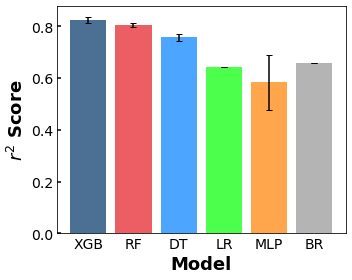

In [43]:
# Create lists for the plot
models = ['XGB', 'RF', 'DT', 'LR', 'MLP', 'BR']
x_pos = np.arange(len(models))

# put the real numbers here
r2_xgb_mean, r2_rf_mean, r2_dt_mean, r2_lr_mean, r2_mlp_mean, r2_br_mean = \
np.mean(r_squareds_xgb), np.mean(r_squareds_rf), np.mean(r_squareds_dt),\
np.mean(r_squareds_lr), np.mean(r_squareds_mlp), np.mean(r_squareds_br)               

r2_xgb_std, r2_rf_std, r2_dt_std, r2_lr_std, r2_mlp_std, r2_br_std = \
np.std(r_squareds_xgb), np.std(r_squareds_rf), np.std(r_squareds_dt),\
np.std(r_squareds_lr), np.std(r_squareds_mlp), np.std(r_squareds_br)


CTEs = [r2_xgb_mean, r2_rf_mean, r2_dt_mean, r2_lr_mean, r2_mlp_mean, r2_br_mean]

error = [r2_xgb_std, r2_rf_std, r2_dt_std, r2_lr_std, r2_mlp_std, r2_br_std]

# Build the plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(axis='x', direction='in', length=0, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.7, width=0.8,
       ecolor='black', 
       color= ('#003366', '#E31B23', '#007FFF', '#00FF00', '#FF7F00', '#959595'),
       capsize=3)

ax.set_ylabel('$r^2$ Score')
plt.xlabel('Model', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('$r^2$ Score', fontsize='18', fontname='Arial', fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(models)
#ax.set_title(r'$r^2 Score$')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('error_bars_r2.png', dpi=300)
plt.show()

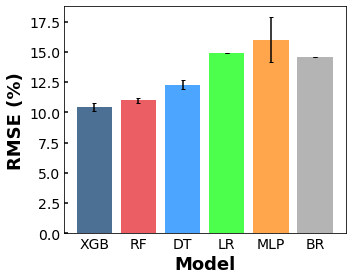

In [44]:
# Create lists for the plot
models = ['XGB', 'RF', 'DT', 'LR', 'MLP', 'BR']
x_pos = np.arange(len(models))

# put the real numbers here
RMSE_xgb_mean, RMSE_rf_mean, RMSE_dt_mean, RMSE_lr_mean, RMSE_mlp_mean, RMSE_br_mean= \
np.mean(RMSEs_xgb), np.mean(RMSEs_rf), np.mean(RMSEs_dt),\
np.mean(RMSEs_lr), np.mean(RMSEs_mlp), np.mean(RMSEs_br) 

RMSE_xgb_std, RMSE_rf_std, RMSE_dt_std, RMSE_lr_std, RMSE_mlp_std, RMSE_br_std = \
np.std(RMSEs_xgb), np.std(RMSEs_rf), np.std(RMSEs_dt),\
np.std(RMSEs_lr), np.std(RMSEs_mlp), np.std(RMSEs_br) 


CTEs = [RMSE_xgb_mean, RMSE_rf_mean, RMSE_dt_mean, RMSE_lr_mean, RMSE_mlp_mean, RMSE_br_mean]

error = [RMSE_xgb_std, RMSE_rf_std, RMSE_dt_std, RMSE_lr_std, RMSE_mlp_std, RMSE_br_std]

# Build the plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(axis='x', direction='in', length=0, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')

ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.7, width=0.8,
       ecolor='black', 
       color= ('#003366', '#E31B23', '#007FFF', '#00FF00', '#FF7F00', '#959595'),
       capsize=2)

ax.set_ylabel('$r^2$ Score')
plt.xlabel('Model', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('RMSE (%)', fontsize='18', fontname='Arial', fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(models)
#ax.set_title(r'$r^2 Score$')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.tight_layout()
plt.savefig('error_bars_RMSE.png', dpi=200)
plt.show()

In [45]:
# Pick the best model
r_squareds_xgb = list()
r_squareds_train_xgb = list()
MAEs_xgb = list()
RMSEs_xgb = list()
RMSEs_train_xgb = list()
start = time.time()
rep = 5

for random_state in range(rep):
    # Instantiate model with 1000 decision trees
    xgb_graphyield = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.7, 
                   learning_rate=0.118, subsample=0.725, min_child_weight=6, 
                   random_state=random_state)

    # Test the model on test data
    xgb_graphyield.fit(train_new_features, train_labels);
    pred_test = xgb_graphyield.predict(test_new_features)
    errors = abs(pred_test - test_labels)
    MAEs_xgb.append(errors)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(pred_test, test_labels)
    RMSEs_xgb.append (m.result().numpy())
    r_squared = r2_score(test_labels, pred_test)
    r_squareds_xgb.append (r_squared)
    
    # training data accuracy
    predictions = xgb_graphyield.predict(train_new_features)
    errors = abs(predictions - train_labels)
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(predictions, train_labels)
    RMSEs_train_xgb.append (m.result().numpy())
    r_squared = r2_score(train_labels, predictions)
    r_squareds_train_xgb.append (r_squared)

print ('mean train r2', np.mean (r_squareds_train_xgb))
print ('mean test r2', np.mean (r_squareds_xgb))

mean train r2 0.8411328718998442
mean test r2 0.8275975454738298


In [46]:
# make the numbers on axis bold
from matplotlib import rc, rcParams
error_group = ['<5%', '5-10%', '10-15%', '15-20%', '>20%']

abs_err = np.abs(pred_test.reshape(-1, 1)-test_labels.reshape(-1, 1))
less_5 = abs_err [abs_err <= 5]
larger_5 = abs_err [abs_err > 5]
larger_5_less_10 = larger_5 [larger_5 <= 10]
larger_10 = abs_err [abs_err > 10]
larger_10_less_15 = larger_10 [larger_10 <= 15]

larger_15 = abs_err [abs_err > 15]
larger_15_less_20 = larger_15 [larger_15 <= 20]
larger_20 = abs_err [abs_err > 20]
n_test = pred_test.shape[0]

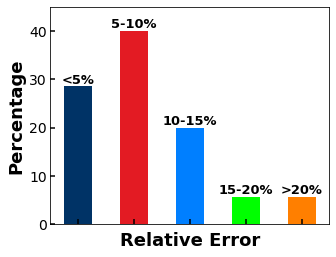

In [47]:
#rc('font', weight='bold')
plt.close()
plt.figure(figsize = (5, 4))
frequencies = [less_5.shape[0]/n_test*100, larger_5_less_10.shape[0]/n_test*100, 
               larger_10_less_15.shape[0]/n_test*100, larger_15_less_20.shape[0]/n_test*100, 
               larger_20.shape[0]/n_test*100]
freq_series = pd.Series(frequencies)
ax = freq_series.plot(kind='bar', color = ['#003366', '#E31B23', '#007FFF', '#00FF00', '#FF7F00', '#959595'])
ax.tick_params(axis='both', which='major', labelsize=28, width=5)
rects = ax.patches
x_labels = [ ]
labels = ['<5%', '5-10%', '10-15%', '15-20%', '>20%']

ax.tick_params(axis='x', direction='in', length=5, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='in', length=5, width=1.5, colors='black', grid_alpha=0, labelsize='14')

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label,fontsize = 13, fontweight='bold',
            ha='center', va='bottom')
ax.set_xticklabels(x_labels)
plt.ylim(0, 45)

plt.yticks(fontsize = 14)
plt.ylabel("Percentage", fontsize=18, fontweight='bold')
plt.xlabel("Relative Error", fontsize=18, fontweight='bold')
plt.savefig('RE_dft_des.jpeg', dpi=300, bbox_inches='tight')

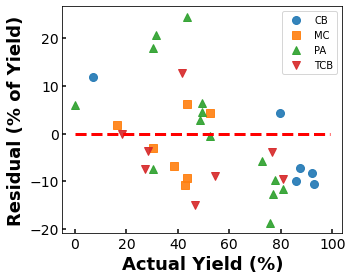

In [48]:
pred_test = xgb_graphyield.predict(test_new_features)
errors_test = (pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['Graphene_Yield_per'] = 100*df_test['Graphene_Yield']

groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend()

x = list(range(0, 100))
y = np.repeat(0, 100)
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (% of Yield)', fontsize='18', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('resVSGY_test.png', dpi=200)

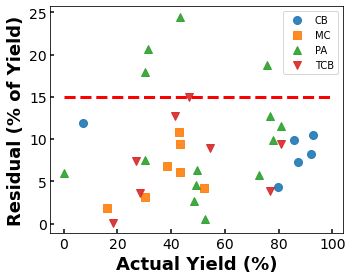

In [49]:
pred_test = xgb_graphyield.predict(test_new_features)
errors_test = abs(pred_test.reshape(-1, 1) - test_labels)
id_errors = list(range(errors_test.shape[0]))
#plt.plot(id_errors, errors_test, c=id_test)

df_test = df.loc[idx_test]
df_test['id_errors'] = id_errors
df_test['errors'] = errors_test
df_test['Graphene_Yield_per'] = 100*df_test['Graphene_Yield']

groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend()

x2 = list(range(0, 100))
y2 = np.repeat(15, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (% of Yield)', fontsize='18', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY_test.png', dpi=200)

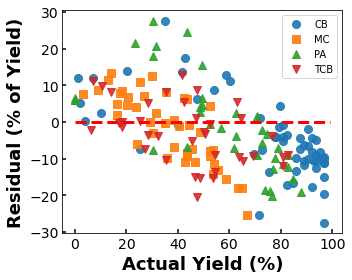

In [50]:
labels = 100*Graphene_Yield
predictions = xgb_graphyield.predict(new_features)
errors_all = (predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = 100*df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend()


x = list(range(0, 100))
y = np.repeat(0, 100)
plt.plot(x, y, linestyle='--', color='red', linewidth='3')
ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Residual (% of Yield)', fontsize='18', fontname='Arial', fontweight='bold')
plt.tight_layout()
plt.tight_layout()
plt.savefig('resVSGY.png', dpi=200)

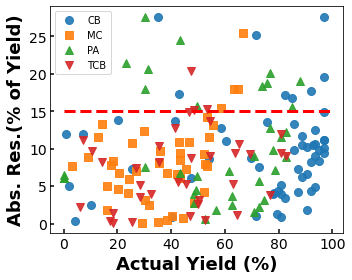

In [51]:
labels = 100*Graphene_Yield
predictions = xgb_graphyield.predict(new_features)
errors_all = abs(predictions.reshape(-1, 1) - labels)

df['errors'] = errors_all
df['Graphene_Yield_per'] = 100*df['Graphene_Yield']

groups = df.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend()

ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Abs. Res.(% of Yield)', fontsize='18', fontname='Arial', fontweight='bold')

x2 = list(range(0, 100))
y2 = np.repeat(15, 100)
plt.plot(x2, y2, linestyle='--', color='red', linewidth='3')

plt.tight_layout()
plt.tight_layout()
plt.savefig('abs_resVSGY.png', dpi=200)

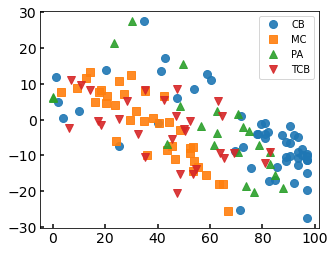

In [52]:
pred_train = xgb_graphyield.predict(train_new_features)
errors_train = (pred_train.reshape(-1, 1) - train_labels)
id_errors = list(range(errors_train.shape[0]))
#plt.plot(id_errors, errors_train, c=id_train)


df_train = df.loc[idx_train]
df_train['id_errors'] = id_errors
df_train['errors'] = errors_train

groups = df_train.groupby(['Material'])

plt.close()
# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.errors, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
plt.legend()

In [53]:
group

,Sample,Material,Atmosphere,Mass,Tube Diam,Pretreat_voltage,Pretreat_highest,Voltage,PulseTime,Res_Volt,...,TwoDtoG,DtoG,FWHM 2D,Norm_charge_tot,Norm_I_Max,charge_density,Final_Current_Percent,errors,Graphene_Yield_per,id_errors
160,161,TCB,vac,200.0,8,270,90,211,270,28.4,...,0.665526,0.446714,48.632321,124.656134,2162.579500,158.250000,0.037591,-11.994543,80.808081,3
162,163,TCB,vac,227.0,8,150,50,212,267,135.3,...,0.684313,0.419454,45.665170,72.173803,573.824229,140.088106,0.943711,8.709914,47.474747,6
170,171,TCB,vac,321.0,8,210,70,160,430,56.0,...,0.631814,0.721581,32.193091,56.169822,676.011215,47.850467,0.096532,-9.423206,63.636364,7
161,162,TCB,vac,232.0,8,270,90,212,268,99.2,...,0.658808,0.474358,48.680058,63.050736,2068.529741,137.068966,0.042497,-9.072973,82.828283,11
163,164,TCB,vac,231.0,8,225,199,209,273,109.5,...,0.624285,0.602525,46.584062,106.222876,2337.194372,135.714286,0.019623,1.135327,64.646465,22
155,156,TCB,vac,419.0,8,225,100,198,319,122.0,...,0.584384,0.465420,49.999333,19.025628,510.602864,45.365155,0.085035,-10.413537,35.353535,25
149,150,TCB,vac,265.0,8,180,90,153,510,26.9,...,0.586744,0.530212,48.109026,54.034218,647.272075,45.033962,0.057367,8.199157,35.353535,27
152,153,TCB,vac,357.0,8,150,50,196,357,129.4,...,0.567537,0.497487,47.728913,21.849912,264.254006,42.823529,0.108751,-20.378962,47.474747,35
153,154,TCB,vac,421.0,8,55,55,197,373,137.2,...,0.522424,0.486614,41.743371,16.798725,116.979549,44.921615,0.200918,-1.359013,18.181818,37
147,148,TCB,vac,267.0,8,55,55,209,275,142.2,...,0.622860,0.408321,48.702225,33.618853,364.777715,117.415730,0.223008,-3.146458,50.505051,40


In [54]:
r2_score(test_labels, pred_test)

0.8284613408961463

/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


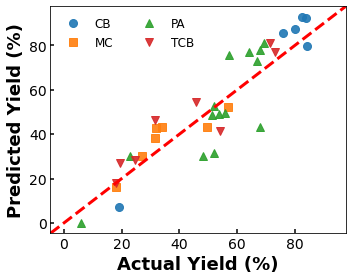

In [55]:
df_test = df.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels
groups = df_test.groupby(['Material'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true,  marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
#plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2, y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_materialgroup_83r2.png', dpi=300)


/home/kianoosh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


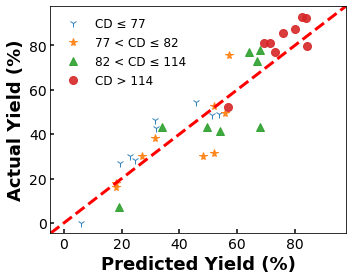

In [56]:
# Distribution of Graphene_yield with  CD density groups
cv = np.array (df_test['charge_density'])
Qs = np.quantile (cv, [0.25, 0.5, 0.75])

cv_class = cv
cv_class = np.where(cv <= Qs[0], 0, cv_class)
cv_class = np.where((cv > Qs[0]) & (cv <= Qs[1]), 1, cv_class)
cv_class = np.where((cv > Qs[1]) & (cv <= Qs[2]), 2, cv_class)
cv_class = np.where(cv > Qs[2], 3, cv_class)

# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)
df_test['cv_class'] = cv_class
groups = df_test.groupby(['cv_class'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['1', '*', '^', 'o']
colors=['#E31B23', '#007FFF', '#00FF00', '#FF7F00']
#colors = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', #color=colors[counter],
            ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(('CD ≤ {}'.format(int(Qs[0])),
           '{} < CD ≤ {}'.format(int(Qs[0]), int(Qs[1])),
           '{} < CD ≤ {}'.format(int(Qs[1]), int(Qs[2])),
           'CD > {}'.format(int(Qs[-1]))), 
          frameon=False, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_cvgroup.png', dpi=300)
plt.show()

[[43.4343434]]
[[ 8.38365759e+01  1.25000000e+02  7.20000000e+00  6.20000000e+01
   4.24000000e+01  0.00000000e+00  0.00000000e+00 -2.71362485e-01
  -0.00000000e+00  2.03000000e+02  2.64000000e+02  5.98162025e-01
   0.00000000e+00  0.00000000e+00  9.98592526e-02  1.24054541e+03
   5.60026321e+01  1.00713375e+00]]
r2 score before removal=  0.8284613408961463
r2 score 99% outlier removed=  0.8555091508357453


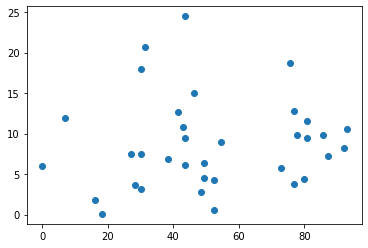

In [57]:
# find the outlier of the tested model
test_error = abs(pred_test.reshape(pred_test.shape[0], 1)-test_labels)
plt.scatter(test_labels, test_error)

error_99quan = np.quantile(test_error, 0.99)
error_99quan_index = np.where (test_error > error_99quan)[0] 
print (test_labels[error_99quan_index])
print (test_new_features[error_99quan_index])

r_squared_test = r2_score(test_labels, pred_test)
print('r2 score before removal= ', r_squared_test)

r_squared_test = r2_score(np.delete (test_labels, error_99quan_index), 
                          np.delete (pred_test, error_99quan_index))
print('r2 score 99% outlier removed= ', r_squared_test)

(-0.38667603126605865, 1.3620144828490697e-07)

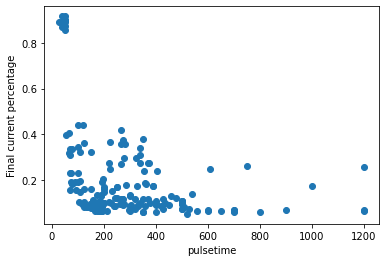

In [58]:
# the higher the pulsetime, the lower the Final current percentage
plt.scatter(pulsetime, Final_Current_Percent_predicted)
plt.xlabel ('pulsetime')
plt.ylabel ('Final current percentage')

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )

Final_Current_Percent_predicted_ = Final_Current_Percent_predicted.reshape(
                                   Final_Current_Percent_predicted.shape[0], )

pearsonr(pulsetime_, Final_Current_Percent_predicted_)

(-0.20667910946767634, 0.0062145364035489006)

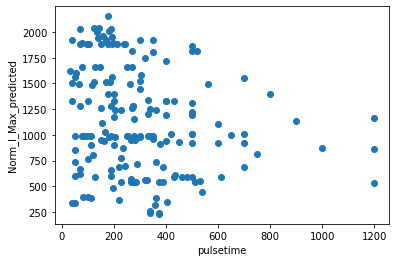

In [59]:
plt.scatter(pulsetime, Norm_I_Max_predicted)
plt.xlabel ('pulsetime')
plt.ylabel ('Norm_I_Max_predicted')

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )
Norm_I_Max_predicted_ = Norm_I_Max_predicted.reshape(
                                   Norm_I_Max_predicted.shape[0], )

pearsonr(pulsetime_, Norm_I_Max_predicted_)

(0.3826150639917454, 1.885391849425535e-07)

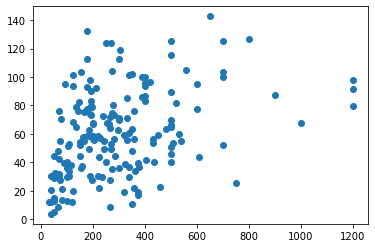

In [60]:
# the higher the pulse time, the higher total charge
plt.scatter(pulsetime, Norm_charge_tot_predicted)

pulsetime_ = pulsetime.reshape(pulsetime.shape[0], )
Norm_charge_tot_predicted_ = Norm_charge_tot_predicted.reshape(
                                   Norm_charge_tot_predicted.shape[0], )

pearsonr(pulsetime_, Norm_charge_tot_predicted_)

In [61]:
# check it with where you define the input to the model
feature_list = ['charge_denisty',
                'pc_materialproperty',
                'res_materialproperty',
                'sa_materialproperty',
                'sp2_materialproperty',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                'GY_modelbasedpred',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power']
# Get numerical feature importances
importances = list(xgb_graphyield.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];
print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.08)
Variable: pc_materialproperty Importance: ('pc_materialproperty', 0.06)
Variable: res_materialproperty Importance: ('res_materialproperty', 0.0)
Variable: sa_materialproperty Importance: ('sa_materialproperty', 0.0)
Variable: sp2_materialproperty Importance: ('sp2_materialproperty', 0.01)
Variable: material_CB Importance: ('material_CB', 0.0)
Variable: material_MC Importance: ('material_MC', 0.0)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_TCB Importance: ('material_TCB', 0.0)
Variable: PulseTime Importance: ('PulseTime', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.03)
Variable: GY_modelbasedpred Importance: ('GY_modelbasedpred', 0.45)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.04)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.0)
Variable: Final_Current_Percent Importance: ('Final_Current_Percent', 0.08)
Variable: Norm_I_Max Importance: ('Norm_I

Mean Absolute Error: 29.5746 units.


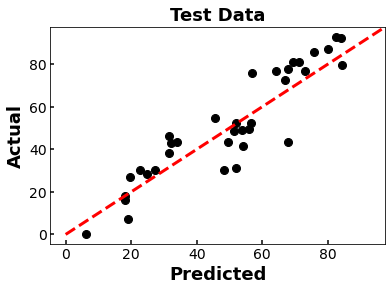

In [63]:
pred_test = xgb_graphyield.predict(test_new_features)
errors_test= abs(pred_train - train_labels)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
# ax.set_xlim(20,105)
# ax.set_ylim(20,105)

# Predicted 2D/G
plt.plot(pred_test, test_labels, 
         linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Predicted', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Actual', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

Mean of I Max CB is  199.5962952631579
Mean of I Max MC is  546.874309090909
Mean of I Max PA is  301.9472116666666
Mean of I Max TCB is  217.5159437837838


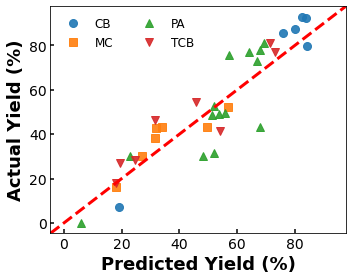

In [64]:
def category_normalization_theonesyoualwaysuse(df):
    groups = df.groupby(['Material'])
    norm_I_Max = []
    norm_charge_tot=[]
    for name, group in groups:
        I_Max_array = np.asfarray(group.I_Max)
        charge_tot_array = np.asfarray(group.Charge_Tot)
        mean_I_Max = np.mean(I_Max_array)
        mean_charge_tot = np.mean(charge_tot_array)
        std_I_Max = np.std(I_Max_array)
        std_charge_tot = np.std(charge_tot_array)
        print("Mean of I Max", name, "is ", mean_I_Max)
        norm_I_Max_cat = np.divide(np.subtract(I_Max_array, mean_I_Max), std_I_Max)
        norm_charge_tot_cat = np.divide(np.subtract(charge_tot_array, mean_charge_tot), std_charge_tot)
        norm_I_Max = np.append(norm_I_Max, norm_I_Max_cat)
        norm_charge_tot = np.append(norm_charge_tot, norm_charge_tot_cat)
    return norm_I_Max, norm_charge_tot


# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Import file
df_test = pd.read_csv('FJH_ML_Final.csv', header=1)
# Create normalized I by category
norm1, norm2 = category_normalization_theonesyoualwaysuse(df_test)
df_test['Norm_I_Max'] = norm1
df_test['Norm_charge_tot'] = norm2
df_test['charge_density'] = df_test['Voltage']*df_test['Cap']/df_test['Mass']
# df_test['test_feature'] = (df_test['Voltage']/df_test['Mass'])#*df_test['PulseTime']
# df_test = df_test[df_test['TwoDtoG']<1.5]
# df_test = df_test[df_test['Graphene_Yield']>20]

# Cut dataframe to only the test set
df_test = df_test.iloc[idx_test]
df_test['y_pred'] = pred_test
df_test['y_true'] = test_labels

groups = df_test.groupby(['Material'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_materialgroup.png', dpi=300)
plt.show()

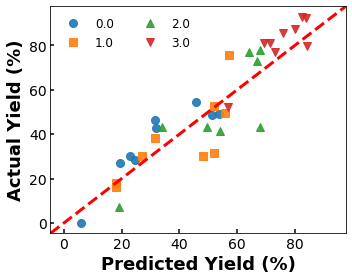

In [65]:
# Distribution of Graphene_yield with  CD density groups
cv = np.array (df_test['charge_density'])
Qs = np.quantile (cv, [0.25, 0.5, 0.75])

cv_class = cv
cv_class = np.where(cv <= Qs[0], 0, cv_class)
cv_class = np.where((cv > Qs[0]) & (cv <= Qs[1]), 1, cv_class)
cv_class = np.where((cv > Qs[1]) & (cv <= Qs[2]), 2, cv_class)
cv_class = np.where(cv > Qs[2], 3, cv_class)

# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)
df_test['cv_class'] = cv_class
groups = df_test.groupby(['cv_class'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformance_cvgroup.png', dpi=300)
plt.show()

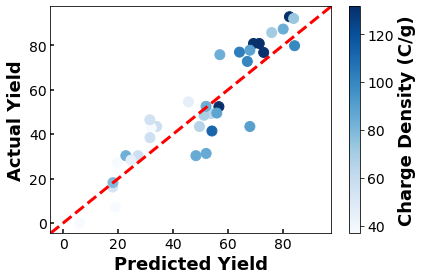

In [66]:
# Plot pred vs. true values for test set, coloring the charge density
groups = df_test.groupby(['Material'])
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')


for name, group in groups:
    p = ax.scatter(group.y_pred, group.y_true, c=group.charge_density, marker='o', s=100, cmap='Blues')
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('Charge Density (C/g)', fontsize='18', fontname='Arial', fontweight='bold')
cb.ax.tick_params(labelsize=14)

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
# ax.legend(fontsize=12)

# Plot
# plt.plot(df['I_Max'],df['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
# plt.savefig('XGB_Regression_Performance_colorChargeDensity.png', dpi=300)
plt.show()

In [67]:
# outside test (Need to ask Jacob the details, material, atmosphere)
filename = 'FJH_ML_MBO_Yield4_modified.csv'
df_testBO0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
df_testBO = df_testBO0

# Only works for test that are TCB material !!!!!!
Material_CB_testBO = np.array (df_testBO['Material']).reshape(-1, 1)
Material_CB_testBO [:] = 0
Material_MC_testBO = np.zeros_like (Material_CB_testBO)
Material_PA_testBO = np.zeros_like (Material_CB_testBO)
Material_TCB_testBO = np.zeros_like (Material_CB_testBO)
Material_TCB_testBO [:] = 1
material_type_testBO = np.concatenate ((Material_CB_testBO, 
                                        Material_MC_testBO, 
                                        Material_PA_testBO,
                                        Material_TCB_testBO), axis=1)
# multiply constants to the matrix for the materials
# the constant calculated from [Init_R, Res_Drop, Volt_Drop] --> current quantities
material_type_GY_coef_testBO = material_type_testBO * CB_MC_PA_TCB_coef_average

# assumed the experiments were done under vaccum
Atmosphere_air_testBO = np.array (df_testBO['Atmosphere']).reshape(-1, 1)
Atmosphere_air_testBO [:] = 0
Atmosphere_arg_testBO = np.zeros_like (Atmosphere_air_testBO)
atmosphere_type_testBO = np.concatenate ((Atmosphere_air_testBO, 
                                          Atmosphere_arg_testBO ), axis=1)

# base 60mF as base and the number in excel file of 18mF
df_testBO['Cap'] = 60 + df_testBO['Cap']*18
charge_density_testBO = np.array (df_testBO['Voltage']*df_testBO['Cap']/
                                  df_testBO['Mass']).reshape(-1, 1)
pulsetime_testBO = np.array (df_testBO['PulseTime']).reshape(-1, 1)
Pretreat_voltage_testBO = np.array (df_testBO['Pretreat_voltage']).reshape(-1, 1)
voltage_testBO = np.array (df_testBO['Voltage']).reshape(-1, 1)
mass_testBO = np.array (df_testBO['Mass']).reshape(-1, 1)
Graphene_Yield_testBO = np.array (df_testBO['Graphene_Yield']).reshape(-1, 1)

In [68]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef_testBO = material_type_testBO*CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef_testBO = material_type_testBO*CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef_testBO = material_type_testBO*CB_MC_PA_coef_Norm_charge_tot

# the features should follow the same order as fitting the model
# 1) Final_I prediction
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_I_Finalperc_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Final_Current_Percent_predicted_testBO = xgbr_final_I_percent.predict(features_testBO)

# 2) norm_I_Max prediction
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_Norm_I_Max_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Norm_I_Max_predicted_testBO = xgbr_norm_I_max.predict(features_testBO)

# 3) norm_Charge_total
features_testBO = np.concatenate ((charge_density_testBO,
                                   pulsetime_testBO,
                                   material_type_Norm_charge_Tot_coef_testBO,
                                   atmosphere_type_testBO,
                                   Pretreat_voltage_testBO), axis=1)
Norm_charge_tot_testBO = xgbr_norm_charge_total.predict(features_testBO)

In [69]:
# physics model prediction: fixed model (trained coefficients) predicting GY
X_CB_MC_PA_TCB_ps_res_sa_sp2_BO = np.matmul(material_type_testBO, 
                                            CB_MC_PA_TCB_ps_res_sa_sp2)
phys_mdl_input = np.concatenate((np.array(((df_testBO['Voltage']**1)*
                                  ((df_testBO['Mass']/100)**-1)*
                                  (df_testBO['Cap']**1))**2*1e-9).reshape(-1, 1),
                                  ((np.array(df_testBO['Pretreat_voltage'])**0.5)*1e-2).reshape(-1, 1),
                                  ((Norm_I_Max_predicted_testBO.reshape(-1, 1))**1)*1e-2,
                                  (np.array(df_testBO['PulseTime']).reshape(-1, 1))**0.5,
                                  ((np.array(Norm_charge_tot_testBO.reshape(-1, 1)))**1)*1e-2,
                                  (np.array (df_testBO['Mass']).reshape (-1, 1))*1e-2 ,
                                  (np.array (df_testBO['Cap']).reshape (-1, 1))*1e-1,
                                  X_CB_MC_PA_TCB_ps_res_sa_sp2_BO,
                                  ), axis=1)
phys_pred_BO = phys_reg_mdl.predict (phys_mdl_input)
r2_score (Graphene_Yield_testBO, phys_pred_BO)

0.6158360629256319

In [70]:
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix_BO = np.matmul(material_type_testBO, CB_MC_PA_TCB_res)
heat_power_BO = np.array (df_testBO['Voltage']*df_testBO['Voltage']/
                          resistance_matrix_BO*df_testBO['PulseTime']*(1e-6)).reshape(-1, 1)

features_testBO = np.concatenate ((charge_density_testBO,
                                   X_CB_MC_PA_TCB_ps_res_sa_sp2_BO,
                                   material_type_GY_coef_testBO,
                                   pulsetime_testBO,
                                   Pretreat_voltage_testBO,
                                   phys_pred_BO.reshape(-1, 1),
                                   atmosphere_type_testBO,
                                   Final_Current_Percent_predicted_testBO.reshape(-1, 1),
                                   Norm_I_Max_predicted_testBO.reshape(-1, 1),
                                   Norm_charge_tot_testBO.reshape(-1, 1),
                                   heat_power_BO
                                  ), axis=1)

In [73]:
graphene_yield_testBO = np.array (df_testBO['Graphene_Yield']).reshape(-1, 1)
graphene_yield_testBO = 100*graphene_yield_testBO
graphene_yield_testBO_predicted = xgb_graphyield.predict (features_testBO)

print ('R-squared: ', r2_score(graphene_yield_testBO, graphene_yield_testBO_predicted))
print ('RMSE: ', np.sqrt(mean_squared_error(graphene_yield_testBO, graphene_yield_testBO_predicted)))

R-squared:  0.8000713405502101
RMSE:  11.772680508796949


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


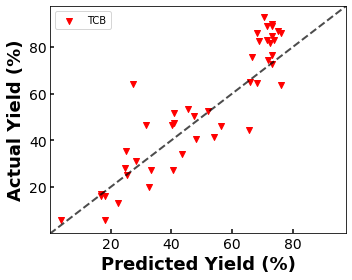

In [74]:
# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
plt.scatter (graphene_yield_testBO_predicted, graphene_yield_testBO, marker='v', 
             color='red', label='TCB')


ax.legend('TCB', fontsize=12, loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

ax.set_xlim(min(xmin, ymin), max(ymax, xmax))
ax.set_ylim(min(xmin, ymin), max(ymax, xmax))
# Make a red line to show perfect predictions
x2 = np.arange(0, 100)
y2 = np.arange(0, 100)
#y2 = np.arange(0.1*ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='black', alpha=0.7)
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('XGBoost_testBOsamples.png', dpi=300)
plt.show()

In [107]:
# Future experimental trial: call it newexp
filename = 'New_experimental_trial.csv'
df_newexp0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=0)
df_newexp = df_newexp0.copy()

# Only works for test that are TCB material !!!!!!
material_type_newexp = np.asarray (df_newexp.loc[:, ('CB_per', 'MC_per', 'PA_per', 'TCB_per')])
# multiply constants to the matrix for the materials
# the constant calculated from [Init_R, Res_Drop, Volt_Drop] --> current quantities
material_type_GY_coef_newexp = material_type_newexp * CB_MC_PA_TCB_coef_average

# assumed the experiments were done under vaccum
atmos_dummies = pd.get_dummies(df_newexp['Atmosphere_type'])
atmosphere_type_newexp = np.concatenate ((np.array(atmos_dummies['air']).reshape(-1, 1), 
                                          np.array(atmos_dummies['arg']).reshape(-1, 1)), axis=1)

# base 60mF as base and the number in excel file of 18mF
df_newexp['Cap'] = 60 + df_newexp['Cap']*18
charge_density_newexp = np.array (df_newexp['Voltage']*df_newexp['Cap']/
                                  df_newexp['Mass']).reshape(-1, 1)
pulsetime_newexp = np.array (df_newexp['PulseTime']).reshape(-1, 1)
Pretreat_voltage_newexp = np.array (df_newexp['Pretreat_voltage']).reshape(-1, 1)
voltage_newexp = np.array (df_newexp['Voltage']).reshape(-1, 1)
mass_newexp = np.array (df_newexp['Mass']).reshape(-1, 1)
Graphene_Yield_newexp = np.array (df_newexp['Basemodel_Graphene_Yield']).reshape(-1, 1)

In [109]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef_newexp = material_type_newexp*CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef_newexp = material_type_newexp*CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef_newexp = material_type_newexp*CB_MC_PA_coef_Norm_charge_tot

# the features should follow the same order as fitting the model
# 1) Final_I prediction
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_I_Finalperc_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Final_Current_Percent_predicted_newexp = xgbr_final_I_percent.predict(features_newexp)

# 2) norm_I_Max prediction
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_Norm_I_Max_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Norm_I_Max_predicted_newexp = xgbr_norm_I_max.predict(features_newexp)

# 3) norm_Charge_total
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_Norm_charge_Tot_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Norm_charge_tot_newexp = xgbr_norm_charge_total.predict(features_newexp)

In [111]:
# physics model prediction: fixed model (trained coefficients) predicting GY
X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp = np.matmul(material_type_newexp, 
                                            CB_MC_PA_TCB_ps_res_sa_sp2)
phys_mdl_input = np.concatenate((np.array(((df_newexp['Voltage']**1)*
                                  ((df_newexp['Mass']/100)**-1)*
                                  (df_newexp['Cap']**1))**2*1e-9).reshape(-1, 1),
                                  ((np.array(df_newexp['Pretreat_voltage'])**0.5)*1e-2).reshape(-1, 1),
                                  ((Norm_I_Max_predicted_newexp.reshape(-1, 1))**1)*1e-2,
                                  (np.array(df_newexp['PulseTime']).reshape(-1, 1))**0.5,
                                  ((np.array(Norm_charge_tot_newexp.reshape(-1, 1)))**1)*1e-2,
                                  (np.array (df_newexp['Mass']).reshape (-1, 1))*1e-2 ,
                                  (np.array (df_newexp['Cap']).reshape (-1, 1))*1e-1,
                                  X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp,
                                  ), axis=1)
phys_pred_newexp = phys_reg_mdl.predict (phys_mdl_input)
r2_score (Graphene_Yield_newexp, phys_pred_newexp)

-0.48054981850230716

In [114]:
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix_newexp = np.matmul(material_type_newexp, CB_MC_PA_TCB_res)
heat_power_newexp = np.array (df_newexp['Voltage']*df_newexp['Voltage']/
                          resistance_matrix_newexp*df_newexp['PulseTime']*(1e-6)).reshape(-1, 1)

features_newexp = np.concatenate ((charge_density_newexp,
                                   X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp,
                                   material_type_GY_coef_newexp,
                                   pulsetime_newexp,
                                   Pretreat_voltage_newexp,
                                   phys_pred_newexp.reshape(-1, 1),
                                   atmosphere_type_newexp,
                                   Final_Current_Percent_predicted_newexp.reshape(-1, 1),
                                   Norm_I_Max_predicted_newexp.reshape(-1, 1),
                                   Norm_charge_tot_newexp.reshape(-1, 1),
                                   heat_power_newexp
                                  ), axis=1)

In [116]:
graphene_yield_newexp = np.array (df_newexp['Basemodel_Graphene_Yield']).reshape(-1, 1)
graphene_yield_newexp = 100*graphene_yield_newexp
graphene_yield_newexp_predicted = xgb_graphyield.predict (features_newexp)

print ('R-squared: ', r2_score(graphene_yield_newexp, graphene_yield_newexp_predicted))
print ('RMSE: ', np.sqrt(mean_squared_error(graphene_yield_newexp, graphene_yield_newexp_predicted)))

R-squared:  -6.578533174104286
RMSE:  5799.661237459674


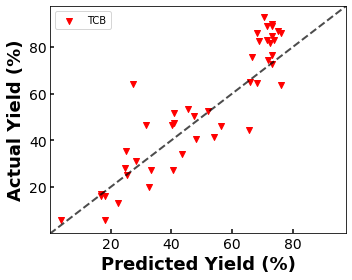

In [117]:
# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
plt.scatter (graphene_yield_testBO_predicted, graphene_yield_testBO, marker='v', 
             color='red', label='TCB')


ax.legend('TCB', fontsize=12, loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

ax.set_xlim(min(xmin, ymin), max(ymax, xmax))
ax.set_ylim(min(xmin, ymin), max(ymax, xmax))
# Make a red line to show perfect predictions
x2 = np.arange(0, 100)
y2 = np.arange(0, 100)
#y2 = np.arange(0.1*ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='black', alpha=0.7)
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('XGBoost_testBOsamples.png', dpi=300)
plt.show()

In [121]:
df_newexp['mlpred_Graphene_Yield'] = graphene_yield_newexp_predicted
df_newexp

,Sample,CB_per,MC_per,PA_per,TCB_per,Atmosphere_type,Mass,Pretreat_voltage,Voltage,PulseTime,Cap,Basemodel_Graphene_Yield,mlpred_Graphene_Yield
0,1,0.5,0.0,0.5,0.0,air,196,190,189,466,2274,85.281385,66.712914
1,2,0.5,0.0,0.5,0.0,air,184,265,207,109,2436,72.222222,75.231255
2,3,0.0,0.0,0.5,0.5,vac,334,220,214,451,2598,69.968920,57.896545
3,4,0.0,0.0,0.5,0.5,vac,266,232,212,179,2760,75.757576,67.048782
4,5,0.0,0.5,0.5,0.0,vac,261,257,225,241,1950,52.525252,56.752670
5,6,0.0,0.5,0.0,0.5,vac,264,150,185,353,2436,51.190476,56.121803
6,7,0.5,0.5,0.0,0.0,vac,252,155,185,117,2112,40.305113,71.829857
7,8,0.5,0.0,0.0,0.5,vac,258,42,175,175,2274,25.324675,71.604683
8,9,0.0,0.5,0.0,0.5,vac,339,147,203,292,1788,19.191919,56.121803
9,10,0.0,0.5,0.5,0.0,arg,330,210,185,338,2598,48.484848,55.935093


In [ ]:
print ('End!!!')